In [ ]:
# --- Spark & GraphFrames Setup ---
import os
from pyspark.sql import SparkSession

os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.4-spark3.5-s_2.12 pyspark-shell"

spark = SparkSession.builder \
    .appName("PCOS Graph with Real Features") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from graphframes import GraphFrame

In [ ]:
# --- Load PCOS dataset ---
df = pd.read_csv("pcos_rotterdam_balanceado.csv")

# Rename columns for compatibility
df = df.rename(columns={
    "Testosterone_Level(ng/dL)": "Testosterone",
    "Menstrual_Irregularity": "Menstrual",
    "Antral_Follicle_Count": "Follicles"
})

# Select relevant features for similarity graph
df = df[["Age", "BMI", "Menstrual", "Testosterone", "Follicles"]].dropna().reset_index()
df = df.rename(columns={"index": "id"})
df["id"] = df["id"].astype(str)

# Normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[["Age", "BMI", "Menstrual", "Testosterone", "Follicles"]] = scaler.fit_transform(df[["Age", "BMI", "Menstrual", "Testosterone", "Follicles"]])

# --- Build similarity-based edges ---
from scipy.spatial.distance import cdist

X = df[["Age", "BMI", "Menstrual", "Testosterone", "Follicles"]]
dist_matrix = cdist(X, X, metric="euclidean")
threshold = 0.6
edges_list = []

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if dist_matrix[i][j] < threshold:
            edges_list.append((df.iloc[i]["id"], df.iloc[j]["id"]))
            edges_list.append((df.iloc[j]["id"], df.iloc[i]["id"]))


In [ ]:
# Convert to Spark DataFrames
vertices = spark.createDataFrame(df)
edges_df = pd.DataFrame(edges_list, columns=["src", "dst"])
edges = spark.createDataFrame(edges_df)

# --- Build GraphFrame ---
graph = GraphFrame(vertices, edges)

# --- Show vertices and edges ---
print("Patients (Vertices):")
graph.vertices.show(truncate=False)

print("Similarity Edges:")
graph.edges.show(truncate=False)

Patients (Vertices):
+---+-------------------+-------------------+---------+-------------------+--------------------+
|id |Age                |BMI                |Menstrual|Testosterone       |Follicles           |
+---+-------------------+-------------------+---------+-------------------+--------------------+
|0  |0.42307692307692313|0.3508287292817679 |0.0      |0.22088006902502158|0.16666666666666669 |
|1  |0.07692307692307698|0.33149171270718225|0.0      |0.3356341673856773 |0.08333333333333333 |
|2  |0.1923076923076924 |0.4033149171270718 |0.0      |0.42105263157894735|0.19444444444444448 |
|3  |0.03846153846153855|0.6685082872928177 |1.0      |0.4935289042277826 |0.9444444444444443  |
|4  |0.03846153846153855|0.48066298342541425|0.0      |0.24935289042277822|0.055555555555555566|
|5  |0.1923076923076924 |0.3342541436464088 |0.0      |0.13977566867989646|0.055555555555555566|
|6  |0.11538461538461542|0.4640883977900552 |0.0      |0.2044866264020708 |0.027777777777777776|
|7  |0.30

In [ ]:
# --- PageRank ---
pageRankResults = graph.pageRank(resetProbability=0.15, maxIter=10)
print("PageRank Results:")
pageRankResults.vertices.select("id", "pagerank").orderBy("pagerank", ascending=False).show(truncate=False)


PageRank Results:
+----+------------------+
|id  |pagerank          |
+----+------------------+
|1837|1.5677420597605771|
|47  |1.5563517494655408|
|1653|1.5398182638361884|
|2161|1.5361310107253088|
|2915|1.5288554654961133|
|186 |1.5231144216978951|
|800 |1.5211791224547866|
|706 |1.5166576694476541|
|1158|1.5144849997946226|
|864 |1.5138917061295276|
|2925|1.5083329214696006|
|1785|1.5030354481507477|
|1965|1.494793207433116 |
|282 |1.4929273414564903|
|1239|1.4919542013253864|
|2467|1.4899911873376022|
|595 |1.4888343714427636|
|2563|1.4887440484194159|
|63  |1.4695385008192579|
|1481|1.4665561094279154|
+----+------------------+
only showing top 20 rows



In [ ]:
# --- Shortest Paths ---
ids = [row["id"] for row in graph.vertices.limit(10).collect()]
landmarks = ids[:2]
shortestPaths = graph.shortestPaths(landmarks=landmarks)
print(f"Shortest Paths from {landmarks}:")
shortestPaths.select("id", "distances").show(truncate=False)

Shortest Paths from ['0', '1']:
+---+----------------+
|id |distances       |
+---+----------------+
|0  |{0 -> 0, 1 -> 1}|
|1  |{0 -> 1, 1 -> 0}|
|2  |{0 -> 1, 1 -> 1}|
|3  |{}              |
|4  |{0 -> 1, 1 -> 1}|
|5  |{0 -> 1, 1 -> 1}|
|6  |{0 -> 1, 1 -> 1}|
|7  |{0 -> 1, 1 -> 1}|
|8  |{}              |
|9  |{0 -> 1, 1 -> 1}|
|10 |{0 -> 1, 1 -> 1}|
|11 |{}              |
|12 |{}              |
|13 |{0 -> 1, 1 -> 2}|
|14 |{0 -> 1, 1 -> 2}|
|15 |{0 -> 1, 1 -> 1}|
|16 |{0 -> 1, 1 -> 2}|
|17 |{}              |
|18 |{0 -> 1, 1 -> 1}|
|19 |{0 -> 1, 1 -> 1}|
+---+----------------+
only showing top 20 rows



In [ ]:
# --- Connected Components ---
spark.sparkContext.setCheckpointDir("/tmp/graphframes-checkpoint")
components = graph.connectedComponents()
print("Connected Components:")
components.select("id", "component").show(truncate=False)


Connected Components:
+---+---------+
|id |component|
+---+---------+
|0  |1        |
|1  |1        |
|2  |1        |
|3  |0        |
|4  |1        |
|5  |1        |
|6  |1        |
|7  |1        |
|8  |0        |
|9  |1        |
|10 |1        |
|11 |0        |
|12 |0        |
|13 |1        |
|14 |1        |
|15 |1        |
|16 |1        |
|17 |0        |
|18 |1        |
|19 |1        |
+---+---------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import col, coalesce, lit

# --- In-Degree ---
in_degrees = graph.inDegrees
print("In-Degree:")
in_degrees.orderBy("inDegree", ascending=False).show(truncate=False)

# --- Out-Degree ---
out_degrees = graph.outDegrees
print("Out-Degree:")
out_degrees.orderBy("outDegree", ascending=False).show(truncate=False)

# --- Total Degree ---
total_degrees = in_degrees.join(out_degrees, on="id", how="outer") \
    .withColumn("inDegree", coalesce(col("inDegree"), lit(0))) \
    .withColumn("outDegree", coalesce(col("outDegree"), lit(0))) \
    .withColumn("totalDegree", col("inDegree") + col("outDegree"))

print("Total Degree (in + out):")
total_degrees.orderBy("totalDegree", ascending=False).show(truncate=False)


In-Degree:
+----+--------+
|id  |inDegree|
+----+--------+
|862 |2128    |
|1952|2128    |
|243 |2128    |
|339 |2128    |
|2730|2128    |
|2420|2128    |
|2898|2127    |
|747 |2127    |
|375 |2127    |
|2657|2127    |
|1471|2127    |
|153 |2127    |
|1392|2127    |
|2124|2127    |
|487 |2127    |
|308 |2126    |
|2947|2126    |
|1580|2126    |
|1023|2126    |
|2958|2126    |
+----+--------+
only showing top 20 rows

Out-Degree:
+----+---------+
|id  |outDegree|
+----+---------+
|862 |2128     |
|1952|2128     |
|243 |2128     |
|339 |2128     |
|2730|2128     |
|2420|2128     |
|2898|2127     |
|747 |2127     |
|375 |2127     |
|2657|2127     |
|1471|2127     |
|153 |2127     |
|1392|2127     |
|2124|2127     |
|487 |2127     |
|308 |2126     |
|2947|2126     |
|1580|2126     |
|1023|2126     |
|2958|2126     |
+----+---------+
only showing top 20 rows

Total Degree (in + out):
+----+--------+---------+-----------+
|id  |inDegree|outDegree|totalDegree|
+----+--------+---------+-------

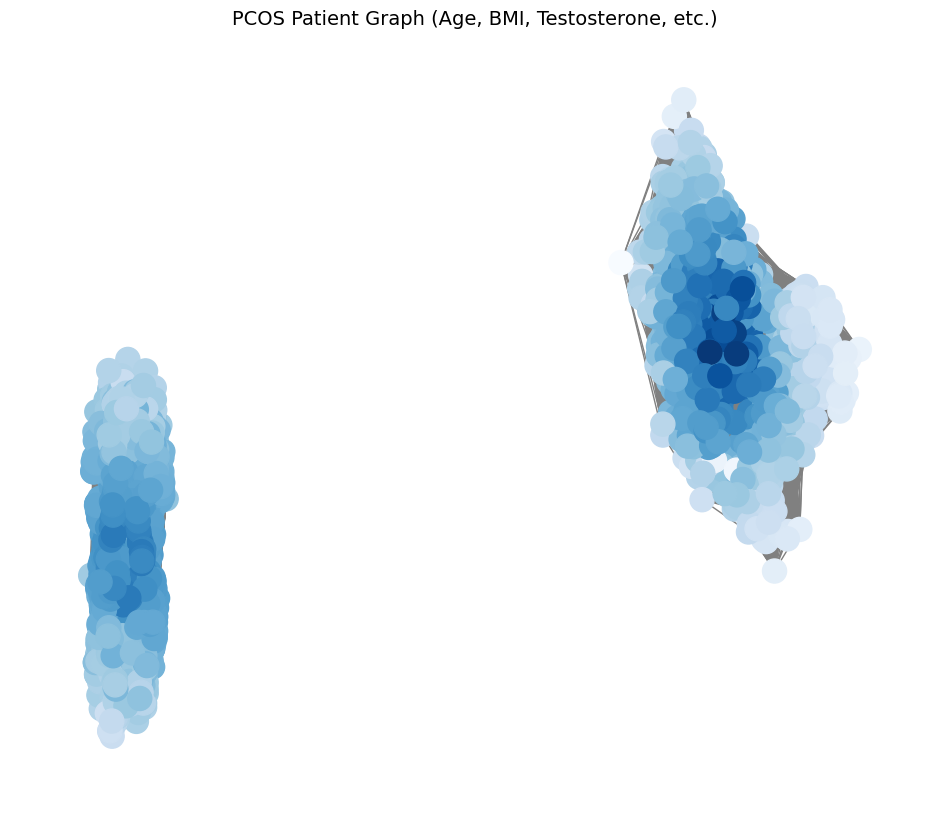

In [ ]:
# --- Visualization ---
vertices_pd = graph.vertices.select("id", "Age", "BMI").toPandas()
pageRank_pd = pageRankResults.vertices.select("id", "pagerank").toPandas()
edges_pd = edges.toPandas()

viz_df = pd.merge(vertices_pd, pageRank_pd, on="id")
viz_df["normPR"] = (viz_df["pagerank"] - viz_df["pagerank"].min()) / (viz_df["pagerank"].max() - viz_df["pagerank"].min())

# NetworkX graph
G_nx = nx.Graph()
for _, row in viz_df.iterrows():
    G_nx.add_node(row["id"], pagerank=row["pagerank"], normPR=row["normPR"])
for _, row in edges_pd.iterrows():
    G_nx.add_edge(row["src"], row["dst"])

pos = nx.spring_layout(G_nx, seed=42)
node_colors = [plt.cm.Blues(G_nx.nodes[node]['normPR']) for node in G_nx.nodes]

plt.figure(figsize=(12, 10))
nx.draw_networkx(G_nx, pos, with_labels=False, node_size=300,
                 node_color=node_colors, font_size=8, edge_color="gray")
plt.title("PCOS Patient Graph (Age, BMI, Testosterone, etc.)", fontsize=14)
plt.axis("off")
plt.show()